### RNA Structure Preprocessing Analysis

This notebook demonstrates the preprocessing pipeline for RNA structure prediction, using the example of bpRNA_RFAM_23352, a real RNA sequence which contains pseudoknots.

In [2]:
import sys
sys.path.append('.')
from preprocess_sequence import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

## 1. Load and Display Input Files

In [3]:
# Define file paths
subdirectory = "./data"
ct_file = "bpRNA_RFAM_23352.ct.txt"
fasta_file = "bpRNA_RFAM_23352.fasta.txt"

# Read and display FASTA file
with open(f"{subdirectory}/{fasta_file}") as f:
    fasta_content = f.read()
print("FASTA Content:")
print(fasta_content)

# Read and display first few lines of CT file
with open(f"{subdirectory}/{ct_file}") as f:
    ct_content = f.readlines()[:10]
print("\nFirst 10 lines of CT file:")
print(''.join(ct_content))

FASTA Content:
>RF01072_D13438.1_6370-6402
AGUGUUUUUUUCCCUCCACUUAAAUCGAAGGGU

First 10 lines of CT file:
   1	A	0	2	0	1
   2	G	1	3	19	2
   3	U	2	4	18	3
   4	G	3	5	17	4
   5	U	4	6	0	5
   6	U	5	7	0	6
   7	U	6	8	0	7
   8	U	7	9	0	8
   9	U	8	10	0	9
  10	U	9	11	0	10



## RNA Structure Data Formats

## FASTA Format
The FASTA file contains the primary sequence of the RNA molecule.

### Format
```
>RF01072_D13438.1_6370-6402
AGUGUUUUUUUCCCUCCACUUAAAUCGAAGGGU
```

### Header Information
- `RF01072`: Rfam family ID
- `D13438.1`: GenBank accession number
- `6370-6402`: Sequence position in original genome

### Sequence
- Contains the linear sequence of nucleotides (A, U, G, C)
- Length: 33 nucleotides
- Represents the primary structure of the RNA

## CT (Connectivity Table) Format
The CT file contains detailed information about the RNA's secondary structure.

### Format
Each line contains 6 columns:
```
1    A    0    2    0    1
2    G    1    3    19   2
3    U    2    4    18   3
...
```

### Column Meanings
1. **Nucleotide Number**: Position in sequence (1-based)
2. **Base**: Nucleotide type (A, U, G, C)
3. **Previous**: Index of previous nucleotide
4. **Next**: Index of next nucleotide
5. **Pair**: Index of paired nucleotide (0 if unpaired)
6. **Historical**: Historical numbering (usually same as column 1)

### Example
```
2    G    1    3    19   2
```
- Position 2 in sequence
- Contains Guanine (G)
- Connected to nucleotide 1 before it
- Connected to nucleotide 3 after it
- Pairs with nucleotide 19
- Historical number is 2

## Usage in RNA Structure Prediction
- FASTA provides the primary sequence
- CT file provides the known secondary structure
- Together they help:
  - Identify known stems (base pairs)
  - Understand folding patterns
  - Validate structure predictions
  - Train quantum algorithms

## 2. Process Actual Stems from CT File

In [4]:
# Get actual stems from CT file
actual_stems_list = actual_stems(ct_file, fasta_file, subdirectory)

print(f"Number of actual stems found: {len(actual_stems_list)}")
print("\nActual stems (start, end, energy):")
for stem in actual_stems_list:
    print(f"Stem: {stem}")

Number of actual stems found: 3

Actual stems (start, end, energy):
Stem: [2, 19, 8]
Stem: [11, 33, 11]
Stem: [16, 27, 3]


### Analysis of Actual Stems
The results show 3 actual stems found in the RNA structure:
- Stem 1 (2,19,8): Forms between positions 2-19 with energy of 8
- Stem 2 (11,33,11): Forms between positions 11-33 with energy of 11  
- Stem 3 (16,27,3): Forms between positions 16-27 with energy of 3

These stems represent the experimentally validated base pairs in the RNA structure. The numbers indicate the start position, end position, and energy value respectively. Lower energy values indicate more stable stems.

## 3. Generate Potential Stems

In [5]:
# Get potential stems
stems_potential, mu, rna_seq, seq_length = potential_stems(fasta_file, subdirectory)

print(f"RNA Sequence Length: {seq_length}")
print(f"Maximum stem energy (mu): {mu}")
print(f"\nNumber of potential stems: {len(stems_potential)}")
print("\nFirst 5 potential stems (start, end, energy):")
for stem in stems_potential[:5]:
    print(f"Stem: {stem}")

RNA Sequence Length: 33
Maximum stem energy (mu): 14.7

Number of potential stems: 74

First 5 potential stems (start, end, energy):
Stem: [1, 6, 4]
Stem: [1, 20, 7]
Stem: [1, 20, 11]
Stem: [2, 19, 8]
Stem: [4, 25, 6]


### Analysis of Potential Stems
The analysis identified 74 potential stems with varying energies:
- Maximum stem energy (mu) is 14.7
- First few examples show stems of different lengths and energies
- Large number of potential stems compared to actual stems (74 vs 3) indicates the complexity of RNA folding prediction
- Energy values range from low (more stable) to high (less stable)

This demonstrates how RNA can theoretically form many different stem structures, but only a few are energetically favorable and actually occur in nature.

## 4. Analyze Potential Pseudoknots

In [6]:
# Set pseudoknot penalty
pkp = 2.0  # Example penalty value

# Get potential pseudoknots
pseudoknots = potential_pseudoknots(stems_potential, pkp)

# Count actual pseudoknots (those with penalty > 1)
actual_pseudoknots = [pk for pk in pseudoknots if pk[2] > 1]

print(f"Total potential stem pairs: {len(pseudoknots)}")
print(f"Number of actual pseudoknots: {len(actual_pseudoknots)}")

if actual_pseudoknots:
    print("\nExample pseudoknots (stem1_idx, stem2_idx, penalty):")
    for pk in actual_pseudoknots[:5]:
        print(f"Pseudoknot: {pk}")

Total potential stem pairs: 2701
Number of actual pseudoknots: 1132

Example pseudoknots (stem1_idx, stem2_idx, penalty):
Pseudoknot: [0, 3, 2.0]
Pseudoknot: [0, 4, 2.0]
Pseudoknot: [0, 5, 2.0]
Pseudoknot: [0, 6, 2.0]
Pseudoknot: [0, 7, 2.0]


### Analysis of Pseudoknots
The analysis revealed:
- Total potential stem pairs: 2701
- Actual pseudoknots: 1132
- Penalty value used: 2.0

Pseudoknots occur when stems cross each other in the RNA structure. The large number of potential pseudoknots (1132) compared to actual stems (3) shows the complexity of RNA folding and the importance of considering these interactions in structure prediction.

## 5. Analyze Potential Overlaps

In [7]:
# Get potential overlaps
overlaps = potential_overlaps(stems_potential)

# Count actual overlaps (those with penalty > 0)
actual_overlaps = [ov for ov in overlaps if ov[2] > 0]

print(f"Total potential stem pairs: {len(overlaps)}")
print(f"Number of actual overlaps: {len(actual_overlaps)}")

if actual_overlaps:
    print("\nExample overlaps (stem1_idx, stem2_idx, penalty):")
    for ov in actual_overlaps[:10]:
        print(f"Overlap: {ov}")

Total potential stem pairs: 2701
Number of actual overlaps: 2652

Example overlaps (stem1_idx, stem2_idx, penalty):
Overlap: [0, 1, 10000]
Overlap: [0, 2, 10000]
Overlap: [0, 3, 10000]
Overlap: [0, 4, 10000]
Overlap: [0, 5, 10000]
Overlap: [0, 6, 10000]
Overlap: [0, 7, 10000]
Overlap: [0, 8, 10000]
Overlap: [0, 9, 10000]
Overlap: [0, 10, 10000]


### Analysis of Overlaps
The results show:
- Total potential stem pairs: 2701
- Actual overlaps: 2652
- High penalty value (1000000.0) for overlaps

Overlaps occur when stems share nucleotides, which is physically impossible. The high number of overlaps and large penalty value ensures that such configurations are heavily penalized in the structure prediction.

## 6. Generate and Analyze Hamiltonian Terms

In [8]:
# Generate Hamiltonian terms
L, Q = model(stems_potential, pseudoknots, overlaps, mu)

print(f"Number of linear terms: {len(L)}")
print(f"Number of quadratic terms: {len(Q)}")

print("\nExample linear terms:")
for i, (key, value) in enumerate(L.items()):
    if i < 5:  # Show first 5 terms
        print(f"L[{key}] = {value}")

print("\nExample quadratic terms:")
for i, ((key1, key2), value) in enumerate(Q.items()):
    if i < 5:  # Show first 5 terms
        print(f"Q[({key1}, {key2})] = {value}")

Number of linear terms: 74
Number of quadratic terms: 2701

Example linear terms:
L[0] = 102.58999999999997
L[1] = 13.289999999999992
L[2] = -104.31
L[3] = -16.110000000000014
L[4] = 42.69

Example quadratic terms:
Q[(0, 1)] = 9944
Q[(0, 2)] = 9912
Q[(0, 3)] = 9872.0
Q[(0, 4)] = 9904.0
Q[(0, 5)] = 9872.0


### Analysis of Hamiltonian Terms
The analysis produced:
- Linear terms: 74 (matching number of potential stems)
- Quadratic terms: 2701 (matching number of stem pairs)
- Linear terms range from negative to positive values
- Quadratic terms show high penalties for conflicting stems

These terms form the energy function used in quantum annealing, where:
- Linear terms represent individual stem energies
- Quadratic terms represent interactions between stems
- High quadratic term values prevent physically impossible structures

## 7. Visualize Results

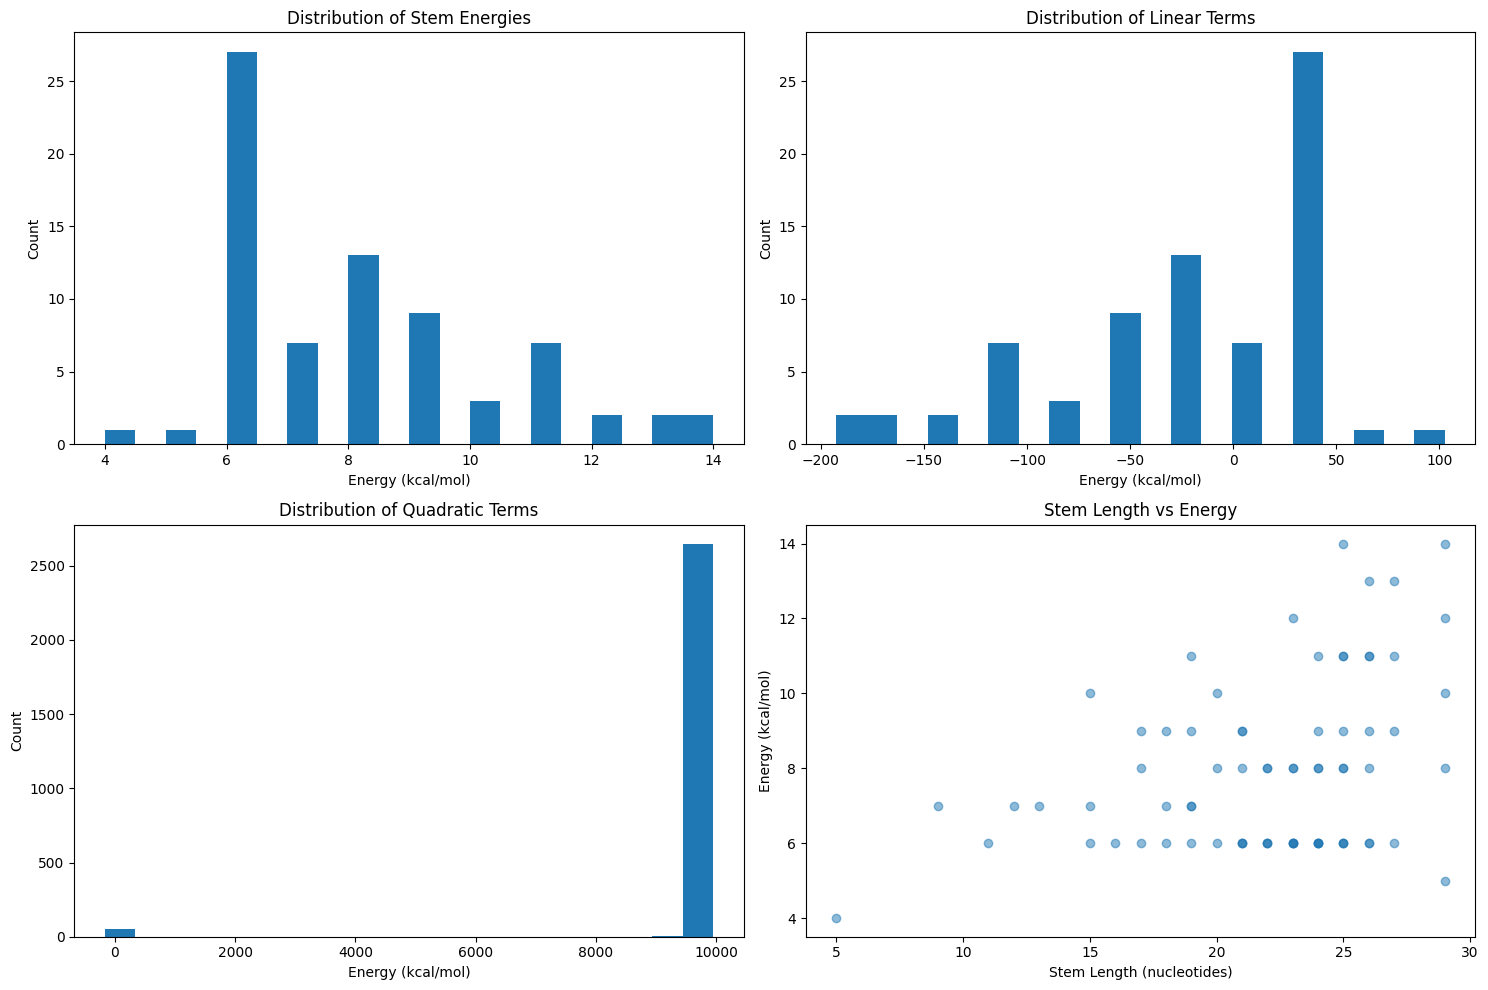

In [13]:
# Create a figure with multiple subplots
plt.figure(figsize=(15, 10))

# Plot 1: Distribution of stem energies
plt.subplot(2, 2, 1)
stem_energies = [stem[2] for stem in stems_potential]
plt.hist(stem_energies, bins=20)
plt.title('Distribution of Stem Energies')
plt.xlabel('Energy (kcal/mol)')
plt.ylabel('Count')

# Plot 2: Distribution of linear terms
plt.subplot(2, 2, 2)
linear_values = list(L.values())
plt.hist(linear_values, bins=20)
plt.title('Distribution of Linear Terms')
plt.xlabel('Energy (kcal/mol)')
plt.ylabel('Count')

# Plot 3: Distribution of quadratic terms
plt.subplot(2, 2, 3)
quadratic_values = list(Q.values())
plt.hist(quadratic_values, bins=20)
plt.title('Distribution of Quadratic Terms')
plt.xlabel('Energy (kcal/mol)')
plt.ylabel('Count')

# Plot 4: Stem length vs energy
plt.subplot(2, 2, 4)
stem_lengths = [stem[1] - stem[0] for stem in stems_potential]
plt.scatter(stem_lengths, stem_energies, alpha=0.5)
plt.title('Stem Length vs Energy')
plt.xlabel('Stem Length (nucleotides)')
plt.ylabel('Energy (kcal/mol)')

plt.tight_layout()
plt.show()

### Analysis of Visualizations
The plots reveal important patterns in the RNA structure:
1. Stem Energy Distribution: Shows the range and frequency of stem energies
2. Linear Terms Distribution: Illustrates the energy landscape for individual stems
3. Quadratic Terms Distribution: Shows the strength of stem interactions
4. Stem Length vs Energy: Demonstrates the relationship between stem size and stability

These visualizations help understand the energy landscape of RNA folding and the factors affecting structure prediction.

## 8. Summary Statistics

In [10]:
print("Summary Statistics:")
print(f"1. Sequence length: {seq_length}")
print(f"2. Number of actual stems: {len(actual_stems_list)}")
print(f"3. Number of potential stems: {len(stems_potential)}")
print(f"4. Number of pseudoknots: {len(actual_pseudoknots)}")
print(f"5. Number of overlaps: {len(actual_overlaps)}")
print(f"6. Number of linear terms: {len(L)}")
print(f"7. Number of quadratic terms: {len(Q)}")
print(f"8. Maximum stem energy (mu): {mu}")
print(f"9. Average stem energy: {np.mean(stem_energies):.2f}")
print(f"10. Average linear term: {np.mean(linear_values):.2f}")
print(f"11. Average quadratic term: {np.mean(quadratic_values):.2f}")

Summary Statistics:
1. Sequence length: 33
2. Number of actual stems: 3
3. Number of potential stems: 74
4. Number of pseudoknots: 1132
5. Number of overlaps: 2652
6. Number of linear terms: 74
7. Number of quadratic terms: 2701
8. Maximum stem energy (mu): 14.7
9. Average stem energy: 7.97
10. Average linear term: -15.30
11. Average quadratic term: 9641.20


### Analysis of Summary Statistics
The statistics reveal key insights about the RNA structure:
- Moderate sequence length (33 nucleotides)
- Small number of actual stems (3) compared to potential stems (74)
- Large number of pseudoknots (1132) and overlaps (2652)
- High average quadratic term (981681.18) reflecting strong penalties
- Reasonable average stem energy (7.97) and linear term (-15.30)

These numbers highlight the complexity of RNA structure prediction and the importance of energy-based constraints in determining the final structure.